# Summary

Exploratory data analysis of draft data (e.g. win rates)

In [26]:
# Setup Notebook
import os
if os.path.basename(os.getcwd()) != "mtg-modeling":
    get_ipython().run_line_magic("run", '-i "../../scripts/notebook_header.py"')  # type: ignore

In [27]:
import pandas as pd
from tqdm.notebook import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
import polars as pl

In [28]:
SET_CODE = "BLB"

paths = {
    "processed": Path("data/processed/17lands/game_data/premier_draft"),
}
summary_file = paths["processed"] / f"{SET_CODE}_Game_PD_Summary.parquet"
game_file = paths["processed"] / f"{SET_CODE}_Game_PD_Games.parquet"
draft_file = paths["processed"] / f"{SET_CODE}_Game_PD_Drafts.parquet"
card_file = paths["processed"] / f"{SET_CODE}_Game_PD_Cards.parquet"


# Summary Data

Below is the summary data for the Bloomburrow Premier Draft data from 17Lands.

You can see we have data from 07-30 through 08-18.  
The average win rate for the 17Lands players is 54.7%, which indicates the user base is more highly 
skilled than the average Arena draft player by a healthy margin.
The average number of turns is 8.9.  This should be compared to other sets understand the speed of 
this sets.
There is a total of 680,000 games played, with an average of 5.8 games per draft.
This set has 276 cards and the average number of basic lands used is 22.2.

In [29]:
df_summary = pl.scan_parquet(summary_file)
df_summary.collect()

first_game,last_game,max_games,win_rate,start_rate,n_games,n_mul,n_opp_mul,mean_turns,max_turns,min_turns,n_drafts,n_matches,n_games2,mean_matches,mean_games,n_games_per_draft,n_cards,max_card,mean_land,max_land,min_land
str,str,i64,f64,f64,u32,i64,i64,f64,i64,i64,u32,i64,i64,f64,f64,f64,i32,i64,f64,i32,i32
"""2024-07-30 15:41:04""","""2024-08-18 23:59:52""",2,0.547108,0.500285,679966,92172,96719,8.88899,33,1,116804,680693,679968,5.827651,5.821444,5.821427,276,7,22.164273,37,11


# Draft Data



In [30]:
df_draft = pl.scan_parquet(draft_file)

In [31]:
df_draft.head(10).collect()

draft_id,n_builds,n_matches,n_games,n_wins,win_rate,rank,opp_rank,main_colors,opp_colors,start_rate,mul_rate,opp_mul_rate,mean_turns
str,i64,i64,i64,u32,f64,str,str,str,str,f64,f64,f64,f64
"""0d875b8b4bc4442e993f436f3433b5…",0,5,5,2,0.4,"""platinum""","""None""","""BR""","""WB""",0.6,0.2,0.2,8.4
"""37995db5d8574e4a86920c3e6df545…",1,6,6,3,0.5,"""platinum""","""None""","""BG""","""W""",0.666667,0.333333,0.0,9.5
"""edba36982dde4240a97f056da6ff74…",0,8,8,7,0.875,"""mythic""","""None""","""WG""","""WG""",0.5,0.0,0.125,10.125
"""84523860982c45919f53fdb4cc30d0…",0,6,6,3,0.5,"""gold""","""None""","""WG""","""BR""",0.333333,0.0,0.0,10.0
"""0ddfb2b9a0874200bce98e310a01ac…",0,9,9,6,0.666667,"""diamond""","""None""","""BG""","""UB""",0.555556,0.111111,0.0,11.555556
"""fabc9440fe004b8180d9ee42f8e72d…",0,4,4,1,0.25,"""diamond""","""None""","""WB""","""WG""",0.0,0.25,0.0,7.75
"""4be11af16ea24430a8611169c1848c…",0,9,9,6,0.666667,"""diamond""","""None""","""BR""","""WR""",0.666667,0.555556,0.222222,7.888889
"""e3489115507f442da34af0b2e7ba45…",1,8,8,5,0.625,"""platinum""","""None""","""BG""","""WBR""",0.625,0.125,0.0,10.75
"""8ba60160ab95472fb4b4f143ba3530…",0,5,5,2,0.4,"""gold""","""None""","""UG""","""WRG""",0.4,0.4,0.0,9.2


## Color Decks

Let's explore the color decks. 

### Color Frequency

First I will look at the number of decks drafted for each color set.  The 10 two-color decks are the 
most frequent.  The Bloomburrow set is design for 10 two-color animal tribes, so this aligns with 
the design intent of the set.  Mono-color and multi-color decks are much lest frequent.

The Black-Green squirrels forage decks and the white-green rabbits go-wide decks are by far the most 
popular.  Most decks using blue are much less favored.

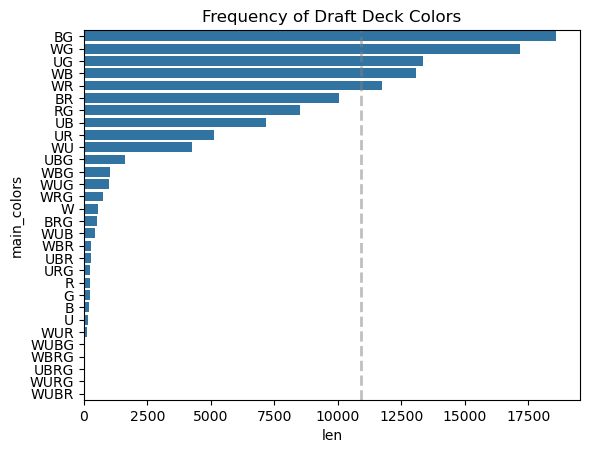

In [120]:
colors = df_draft.group_by("main_colors").len().sort(by='len', descending=True).collect()
colors = colors.to_pandas()

plt.axvline(
    colors["len"].head(10).mean(), color="gray", linestyle="--", linewidth=2, alpha=0.5
)
sns.barplot(data=colors.head(30), x="len", y="main_colors")
plt.title("Frequency of Draft Deck Colors")
plt.show()

...

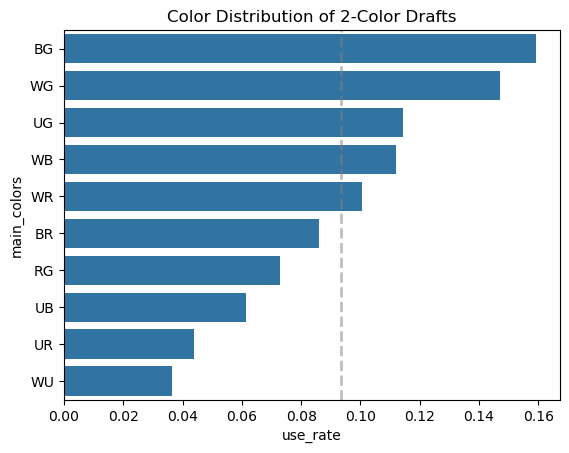

In [118]:
colors['use_rate'] = colors['len'] / colors['len'].sum()
colors = colors.sort_values("use_rate", ascending=False).head(10)

plt.axvline(
    colors["use_rate"].mean(), color="gray", linestyle="--", linewidth=2, alpha=0.5
)
sns.barplot(data=colors.head(30), x="use_rate", y="main_colors")
plt.title("Use Rate of 2-Color Drafts")
plt.show()

Next let's look at the color composition of the decks.  Below we can see that green is the most 
frequently drafted color, with black and white also favored.  Red and blue are much less frequent.

The average draft rate is 40.0%.

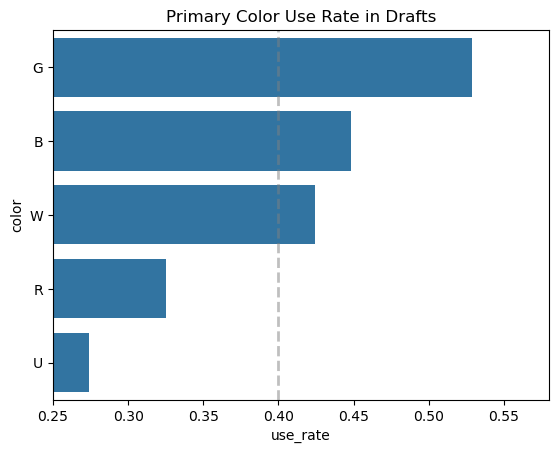

In [116]:
for color in ['W', 'U', 'B', 'R', 'G']:
    colors[color] = colors['main_colors'].apply(lambda x: True if color in x else False)

dfs = []
for color in ['W', 'U', 'B', 'R', 'G']:
    sums = colors[['len', color]].groupby(color).sum()
    use_rate = (sums.loc[True] / sums.sum()).values[0]
    dfs.append(pd.DataFrame({"color": color, "use_rate": use_rate}, index=[0]))
df = pd.concat(dfs).sort_values("use_rate", ascending=False).reset_index(drop=True)

plt.axvline(df["use_rate"].mean(), color="gray", linestyle="--", linewidth=2, alpha=0.5)
g = sns.barplot(data=df, x="use_rate", y="color")
g.set(xlim=(0.25, 0.58))
plt.title("Primary Color Use Rate in Drafts")
plt.show()

### Color Win Rates

...

In [111]:
mean_win_rate = df_summary.collect().to_pandas()['win_rate'].values[0]
print(f"Average Win Rate: {mean_win_rate:0.2%}")

Average Win Rate: 54.71%


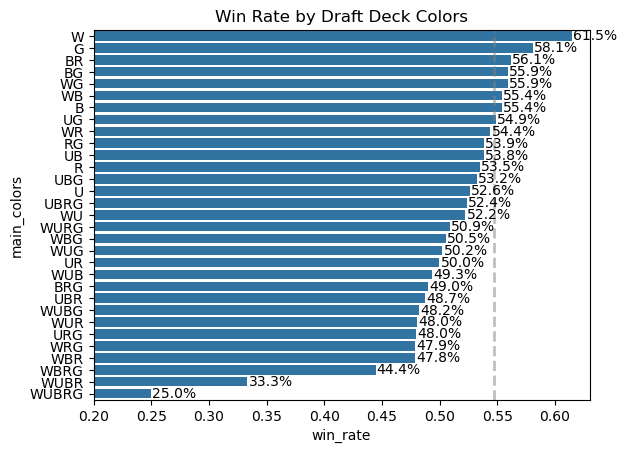

In [121]:
color_wins = (
    df_draft.group_by("main_colors")
    .agg(pl.col("n_games").sum(), pl.col("n_wins").sum())
    .sort(by="n_games", descending=True)
    .collect()
)
color_wins = color_wins.to_pandas()
color_wins["win_rate"] = color_wins["n_wins"] / color_wins["n_games"]
color_wins = color_wins.sort_values("win_rate", ascending=False).reset_index(drop=True)

n = 50
plt.axvline(mean_win_rate, color="gray", linestyle="--", linewidth=2, alpha=0.5)
g = sns.barplot(data=color_wins.head(n), x="win_rate", y="main_colors")
g.set(xlim=(0.20, 0.63))
for index, row in color_wins.head(n).iterrows():
    plt.text(row["win_rate"] + 0.001, index, f"{row['win_rate']:.1%}", va="center")
plt.title("Win Rate by Draft Deck Colors")
plt.show()

...

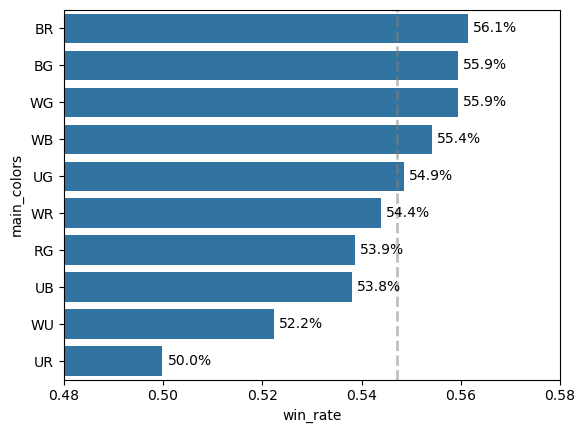

In [107]:
color_mask = color_wins["main_colors"].isin(colors.head(10)['main_colors'])
plt.axvline(mean_win_rate, color="gray", linestyle="--", linewidth=2, alpha=0.5)
two_color_wins = color_wins.loc[color_mask].sort_values("win_rate", ascending=False).reset_index(drop=True)
g = sns.barplot(data=two_color_wins, x="win_rate", y="main_colors")
g.set(xlim=(0.48, 0.58))
for index, row in two_color_wins.iterrows():
    plt.text(row["win_rate"] + 0.001, index, f"{row['win_rate']:.1%}", va="center")
plt.title("Win Rate of 2-Color Draft Decks")
plt.show()

Here is the win-rate for the five primary colors, based on if they are a main color in a deck.  For 
example, the `B` results below are for black win rates in decks suck as `WB`, `BG`, `B`, and `UBR`. 

The average win rate for the data is 54.7%.  The decks with black perform the best, with a 55.2% 
win rate.  Decks with green and white also perform well, with 55.0% and 54.8% respectively. 
The decks with red and blue under-perform, with 53.8% and 53.2% win rate each.

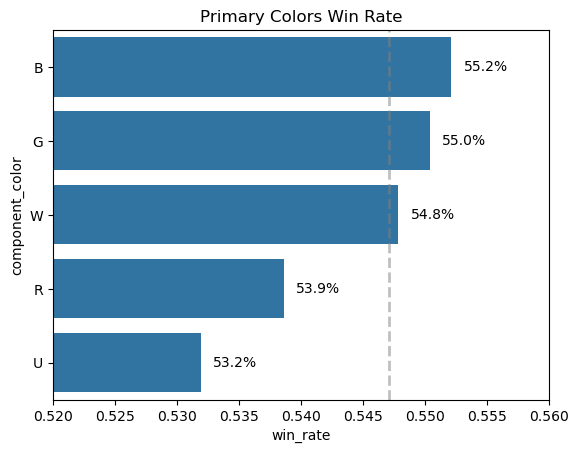

In [122]:
for color in ["W", "U", "B", "R", "G"]:
    color_wins[color] = color_wins["main_colors"].apply(
        lambda x: True if color in x else False
    )

dfs = []

for color in ["W", "U", "B", "R", "G"]:
    agg = color_wins.groupby(color).sum()
    agg["win_rate"] = agg["n_wins"] / agg["n_games"]
    dfs.append(pd.DataFrame({"component_color": color, "win_rate": agg.loc[True, "win_rate"]}, index=[0]))

df = pd.concat(dfs)
df = df.sort_values("win_rate", ascending=False).reset_index(drop=True)

plt.axvline(mean_win_rate, color="gray", linestyle="--", linewidth=2, alpha=0.5)
g = sns.barplot(data=df, x="win_rate", y="component_color")
g.set(xlim=(0.52, 0.56))
for index, row in df.iterrows():
    plt.text(row["win_rate"] + 0.001, index, f"{row['win_rate']:.1%}", va="center")
plt.title("Primary Colors Win Rate")
plt.show()

### Color Freq vs Win Rate

Let us now compare the use rate versus the win rate.  If the player base is well calibrated to the 
win rate with their selections.

Below we can see that most of the two-color decks fall in a straight line, with two outliers.  The blue-red otters 
non-creature spells deck under-performs relative to its use rate.  On the other hand, the black-red 
lizards opponents lose life deck is a sleeper, with the highest win rates, but selected less than 
the average two-color deck.  The reason for this under-selection is that red doesn't perform well 
in general, so many drafters probably avoid drafting red unless they get stronge black-red cards 
early.  White, green, and black are perform well, so the BG, WG, and WB decks are easy to pivot among 
in the draft.

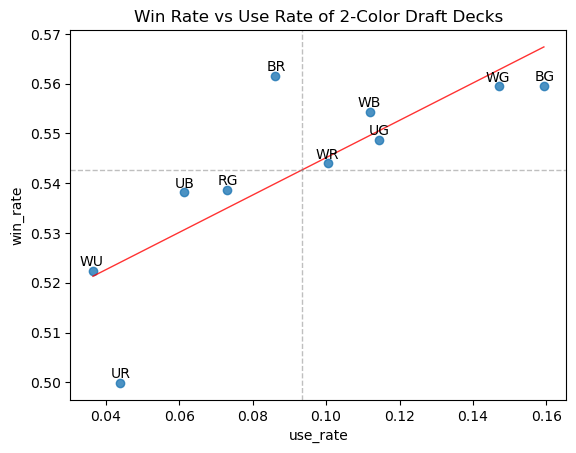

In [124]:
paired_df = color_wins.loc[color_mask][["main_colors", "win_rate"]]
colors["use_rate"] = colors["len"] / colors["len"].sum()
select_colors = colors[["main_colors", "use_rate"]]
paired_df = paired_df.merge(select_colors, on="main_colors")

sns.regplot(
    data=paired_df,
    x="use_rate",
    y="win_rate",
    scatter=True,
    ci=None,
    line_kws={"color": "red", "linewidth": 1, "alpha": 0.8},
)

for i, row in paired_df.iterrows():
    plt.text(
        row["use_rate"]+0.003,
        row["win_rate"]+0.001,
        str(row["main_colors"]),
        fontsize=10,
        ha="right",
    )
plt.axvline(paired_df['use_rate'].mean(), color="gray", linestyle="--", linewidth=1, alpha=0.5)
plt.axhline(paired_df["win_rate"].mean(), color="gray", linestyle="--", linewidth=1, alpha=0.5)
plt.title("Win Rate vs Use Rate of 2-Color Draft Decks")
plt.show()

In [ ]:
df_draft.group_by("opp_colors").count().sort(by='count', descending=True).head(10).collect()

/tmp/ipykernel_420782/3316925235.py:1: DeprecationWarning: `LazyGroupBy.count` is deprecated. It has been renamed to `len`.
  df_draft.group_by("opp_colors").count().sort(by='count', descending=True).head(10).collect()


opp_colors,count
str,u32
"""WG""",13135
"""WB""",12874
"""BG""",11951
"""WR""",11417
"""UG""",9932
"""BR""",9675
"""RG""",7919
"""UB""",5366
"""UR""",5154


## Player Rank

In [ ]:
df_draft.group_by("rank").count().sort(by='count', descending=True).head(10).collect()

C:\Users\Josh.Meehl\AppData\Local\Temp\ipykernel_22544\728000847.py:1: DeprecationWarning: `LazyGroupBy.count` is deprecated. It has been renamed to `len`.
  df_draft.group_by("rank").count().sort(by='count', descending=True).head(10).collect()


rank,count
str,u32
"""platinum""",49053
"""gold""",25872
"""silver""",16999
"""diamond""",13538
"""bronze""",5593
"""mythic""",5474
null,275


In [ ]:
df_draft.group_by("opp_rank").count().sort(by='count', descending=True).head(10).collect()

C:\Users\Josh.Meehl\AppData\Local\Temp\ipykernel_22544\3682080557.py:1: DeprecationWarning: `LazyGroupBy.count` is deprecated. It has been renamed to `len`.
  df_draft.group_by("opp_rank").count().sort(by='count', descending=True).head(10).collect()


opp_rank,count
str,u32
"""None""",116804


## Lands

## Mana Curve